In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

## Downloading the data

For this example, we will use the `Bank Marketing` (more details [here](https://archive.ics.uci.edu/dataset/222/bank+marketing)) dataset. The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. For the purpose of demonstrating `Anonymeter`, we will use this data as if each row would in fact refer to a real individual.

The synthetic version has been generated by `CTGAN` from [pypi ydata-synthetic](https://pypi.org/project/ydata-synthetic/), which is explain here(https://towardsdatascience.com/how-to-generate-real-world-synthetic-data-with-ctgan-af41b4d60fde).

In [3]:
ori = pd.read_csv("../tests/datasets/bank_train.csv")
syn = pd.read_csv("../tests/datasets/bank_syn_ctgan.csv")
control = pd.read_csv("../tests/datasets/bank_control.csv")

In [4]:
ori.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


As visible the dataset contains several demographic information, as well as information regarding the education, financial situation, and personal life of some thousands of "individuals".

### Measuring the singling out risk

The `SinglingOutEvaluator` try to measure how much the synthetic data can help an attacker finding combination of attributes that single out records in the training data. 

With the following code we evaluate the robustness of the synthetic data to "univariate" singling out attacks, which try to find unique values of some attribute which single out an individual. 


In [4]:
evaluator = SinglingOutEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=250)

try:
    evaluator.evaluate(mode='univariate')
    risk = evaluator.risk()
    print(risk)

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.05978880925930717, ci=(0.02025568359720891, 0.09932193492140542))


The risk estimate is accompanied by a confidence interval (at 95% level by default) which accounts for the finite number of attacks performed, 250 in this case. 

Using the `queries()` method, we can see what kind of singling out queries (i.e. the *guesses*) the attacker has come up with:

In [5]:
evaluator.queries()[:3]

['balance == -338', 'duration == 808', 'balance == -689']

As visible it was able to pick up the `balance` has many unique integer values  and that it can provide a powerful handle for singling out. This should result in a singling out risk which is *compatible* within the confidence level with a few percentage points. The actual results can vary depending on notebook execution. 

### Inspecting the results in more details

There are two methods to inspect the results. The high level `risk()` method gives the high level estimation of the privacy risk, and its confidence interval.

In [6]:
evaluator.risk(confidence_level=0.95)

PrivacyRisk(value=0.05978880925930717, ci=(0.02025568359720891, 0.09932193492140542))

for more information, the `results()` method gives the success rates of the three attacks (the "main" one, the baseline one, and the one against control) that enters `Anonymeter` risk calculation.

In [7]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.08635598578808673, error=0.03397365741575495)
Successs rate of baseline attack: SuccessRate(value=0.007566649747722288, error=0.007566649747722288)
Successs rate of control attack: SuccessRate(value=0.028256605314227433, error=0.019073116262201657)


Note that you can obtain the `PrivacyRisk` from the attack results by:

In [8]:
res.risk()

PrivacyRisk(value=0.05978880925930717, ci=(0.02025568359720891, 0.09932193492140542))

### Checking singling out with multivariate predicates

The `SinglingOutEvaluator` can also attack the dataset using predicates which are combining different attributes. These are the so called `multivariate` predicates. 

To run the analysis using the `multivariate` singling out attack, the `mode` parameter of `evaluate` needs to be set correctly. The number of attributes used in the attacker queries via the `n_cols` parameter, set to 4 in this example. 

In [18]:
evaluator = SinglingOutEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=100, # this attack takes longer
                                 n_cols=4)


try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.009811546736227335, ci=(0.0, 0.042514197036475736))


C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.028126814121422983, baseline = 0.06664707419314356. Analysis results cannot be trusted.
  self._sanity_check()


In [19]:
evaluator.queries()[:3]

["balance>= 22161 & default== 'no' & housing== 'yes' & job== 'self-employed'"]

# Measuring the Linkability risk

The `LinkabilityEvaluator` allows one to know how much the synthetic data will help an adversary who tries to link two other datasets based on a subset of attributes. 

To run the `LinkabilityEvaluator` one needs to specify which columns of auxiliary information are available to the attacker, and how they are distributed between the two datasets A and B. This is done using the `aux_cols` parameter.

In [20]:
aux_cols = [
    ['education', 'default', 'housing', 'loan', 'duration'],
    [ 'job', 'balance', 'day', 'age', 'month']
]

evaluator = LinkabilityEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=500,
                                 aux_cols=aux_cols,
                                 n_neighbors=10)

evaluator.evaluate(n_jobs=-2)  # n_jobs follow joblib convention. -1 = all cores, -2 = all execept one
evaluator.risk()

PrivacyRisk(value=0.0, ci=(0.0, 0.014206398873801459))

In [21]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.017705429464314387, error=0.010907639673470899)
Successs rate of baseline attack: SuccessRate(value=0.013735926826160597, error=0.009457172929570103)
Successs rate of control attack: SuccessRate(value=0.019690180783391284, error=0.011560927750002972)


As visible, the attack is not very successful and the linkability risk is low. The `n_neighbor` parameter can be used to allow for weaker indirect links to be scored as successes. It will have an impact on the risk estimate. To check the measured risk for different values of `n_neighbor` you don't have to re-run the evaluation. Rather, do:

In [29]:
print(evaluator.risk(n_neighbors=8))

PrivacyRisk(value=0.0, ci=(0.0, 0.015703774022988948))


# Measuring the Inference Risk

Finally, `anonymeter` allows to measure the inference risk. It does so by measuring the success of an attacker that tries to discover the value of some secret attribute for a set of target records on which some auxiliary knowledge is available.

Similar to the case of the `LinkabilityEvaluator`, the main parameter here is `aux_cols` which specify what the attacker knows about its target, i.e. which columns are known to the attacker. By selecting the `secret` column, one can identify which attributes, alone or in combinations, exhibit the largest risks and thereby expose a lot of information on the original data.

In the following snippet we will measure the inference risk for each column individually, using all the other columns as auxiliary information to model a very knowledgeable attacker. 

In [30]:
columns = ori.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=ori, 
                                   syn=syn, 
                                   control=control,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=200)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))

C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.12225545065524764, baseline = 0.1860305044407253. Analysis results cannot be trusted.
  self._sanity_check()
C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.41169607937395397, baseline = 0.4166018527420677. Analysis results cannot be trusted.
  self._sanity_check()
C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.7992521754549337, baseline = 0.8139694955592747. Analysis results cannot be trusted.
  self._sanity_check()
C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9905773368113667, baseline = 0

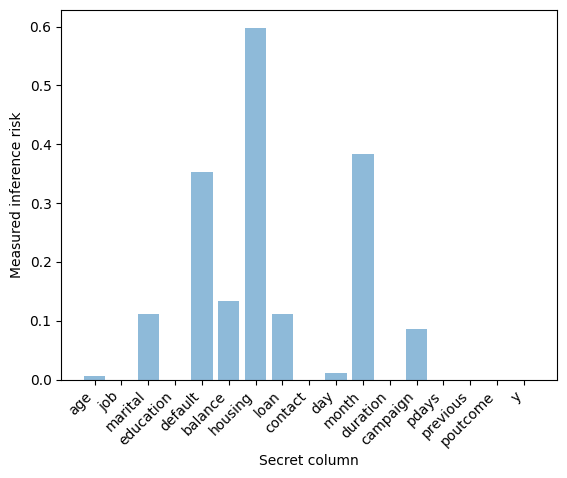

In [31]:
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

As visible, a few columns in the dataset carry a significant inference risk. This means that an attacker in possession of the synthetic dataset can use it to infer some attribute of records in the original data, *beyond what can be explained by utility*.